# AI Lab. Census Variable Classification: Interactive Labeling with BERT Embeddings

This notebook demonstrates how to use BERT embeddings to classify Census data variables.
It follows a practical, iterative approach where we:

1. Fetch real Census variables from the ACS 5-year API
2. Create BERT embeddings for variable descriptions
3. Label a small subset of the data
4. Train a classifier on those labels
5. Use the classifier to predict labels for the remaining variables
6. Measure error rates and iteratively improve the model

## Learning Objectives:
* Understand the difference between BERT and GPT models
* Learn how embeddings can represent text for machine learning tasks
* Practice iterative labeling and model improvement
* Visualize embeddings and see how they cluster
* Measure error rates to track improvement

## Setup Requirements:
* Python 3.7+
* Libraries: pandas, numpy, requests, sentence-transformers, sklearn, matplotlib

## Time Required:
* 90 minutes for full demonstration

## Lab Overview:
1. Start with the BERT vs. GPT discussion
2. Walk through fetching real Census data
3. Show how BERT turns text into vectors (embeddings)
4. Demonstrate the labeling process with student participation
5. Train a classifier and visualize results
6. Iterate through labeling and correction to show improvement

In [1]:
# Step 0. Import necessary libraries
import pandas as pd
import numpy as np
import requests
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time

# Configure matplotlib for Jupyter
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 7)
plt.style.use('ggplot')

print("Environment Ready")

/opt/anaconda3/envs/redaction_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Environment Ready


# LAB NOTES: BERT vs. GPT

## Key Differences:

### Architecture
* BERT: Bidirectional - looks at whole context in both directions
* GPT: Unidirectional - only looks at previous tokens

### Training Tasks
* BERT: Trained on masked language modeling (predict missing words)
* GPT: Trained on next token prediction (complete the sequence)

### Use Cases
* BERT: Understanding tasks (classification, embeddings, etc.)
* GPT: Generation tasks (writing, conversation, etc.)

### Size & Resources
* BERT: Smaller models (110M-340M parameters)
* GPT: Much larger models (175B+ parameters)

### Why We're Using BERT Today:
* We need to understand and categorize Census variables
* We don't need to generate new text
* BERT creates high-quality embeddings with less computational demand
* We can use these embeddings with simple ML models (like KNN)

## Helpful Analogy:
"If GPT is like a novelist who can write creative stories,
BERT is like a literary analyst who deeply understands text structure and meaning."

In [2]:
# Step 1: Fetch ~150 Census Variables from the ACS 5-Year API

def fetch_census_metadata(sample_size=150):
    """
    Fetch ACS 5-Year (2021) variable metadata from the Census API.
    We'll sample ~150 for demonstration (you can adjust).
    """
    print("Fetching Census variables from the ACS 5-Year API...")
    url = "https://api.census.gov/data/2021/acs/acs5/variables.json"
    resp = requests.get(url)
    resp.raise_for_status()
    data_json = resp.json()
    variables_dict = data_json["variables"]
    
    records = []
    for var_id, var_info in variables_dict.items():
        if var_id == "NAME":
            continue
        label = var_info.get("label", "")
        concept = var_info.get("concept", "")
        records.append({
            "id": var_id,
            "description": label,
            "concept": concept
        })
    
    df = pd.DataFrame(records)
    # Sample more than 40 to get interesting variety
    if len(df) > sample_size:
        df = df.sample(sample_size, random_state=42).reset_index(drop=True)

    df["embedding"] = None
    # Two separate columns:
    #  - 'true_label' is what you confirm as ground-truth (like the "gold standard")
    #  - 'predicted_label' is what the model guesses
    df["true_label"] = None
    df["predicted_label"] = None
    df["confidence"] = None
    
    print(f"Fetched {len(df)} ACS variables.")
    return df

# Get our Census data
df = fetch_census_metadata(150)
df.head(10)

Fetching Census variables from the ACS 5-Year API...
Fetched 150 ACS variables.


,id,description,concept,embedding,true_label,predicted_label,confidence
0,B25125_015E,Estimate!!Total:!!Owner occupied:!!Householder...,TENURE BY AGE OF HOUSEHOLDER BY UNITS IN STRUC...,None,None,None,None
1,C23002C_003E,Estimate!!Total:!!Male:!!16 to 64 years:,SEX BY AGE BY EMPLOYMENT STATUS FOR THE POPULA...,None,None,None,None
2,B24116_431E,"Estimate!!Total:!!Explosives workers, ordnance...",DETAILED OCCUPATION FOR THE CIVILIAN EMPLOYED ...,None,None,None,None
3,B04006_045E,Estimate!!Total:!!Guyanese,PEOPLE REPORTING ANCESTRY,None,None,None,None
4,B17010D_026E,Estimate!!Total:!!Income in the past 12 months...,POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILI...,None,None,None,None
5,B09019_024E,Estimate!!Total:!!In households:!!Foster child,HOUSEHOLD TYPE (INCLUDING LIVING ALONE) BY REL...,None,None,None,None
6,B08134_107E,Estimate!!Total:!!Walked:!!30 to 34 minutes,MEANS OF TRANSPORTATION TO WORK BY TRAVEL TIME...,None,None,None,None
7,B24126_386E,"Estimate!!Total:!!Office machine operators, ex...","DETAILED OCCUPATION FOR THE FULL-TIME, YEAR-RO...",None,None,None,None
8,B04004_002E,Estimate!!Total:!!Afghan,PEOPLE REPORTING SINGLE ANCESTRY,None,None,None,None
9,B07408_008E,Estimate!!Total living in area 1 year ago:!!Sa...,GEOGRAPHICAL MOBILITY IN THE PAST YEAR BY MARI...,None,None,None,None


# LAB NOTES: Using Real Census Data

#### Take a moment to explore the data:

1. These are real variables from the American Community Survey 5-Year Estimates
2. Each variable has an ID, description, and concept
3. Observe the types of information captured:
   - Demographics (age, race, sex)
   - Economic indicators (income, poverty)
   - Housing characteristics (occupancy, age of structure)
   - Educational attainment
   - Employment statistics

#### Questions to consider: 

1. "What patterns do you notice in the descriptions?"
2. "How might we organize these variables into categories?"

The 'concept' field gives us the broader category that the Census Bureau uses, 
while the 'description' gives specific details about the variable.

In [3]:
# Cell 2: Compute BERT Embeddings
# Assumes you've run:
# git clone https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

import time
import os
import numpy as np
from sentence_transformers import SentenceTransformer

def combine_text(row):
    """Combine description and concept for richer context"""
    return f"{row['description']} {row['concept']}"

# First, create the combined_text column
df['combined_text'] = df.apply(combine_text, axis=1)

def compute_embeddings(df, text_column='description'):
    """
    Compute BERT embeddings for each text entry.
    """
    print(f"Using BERT model from: {local_model_path}")
    print("Computing embeddings for all variables...")
    start_time = time.time()
    
    embeddings = []
    for text in df[text_column]:
        emb = bert_model.encode(text)
        embeddings.append(emb)
    
    end_time = time.time()
    print(f"Embedding calculation complete! Took {end_time - start_time:.2f} seconds.")
    if embeddings:
        print(f"Each embedding has {len(embeddings[0])} dimensions.")
    
    df["embedding"] = embeddings
    return df, np.array(embeddings)

# Specify the local path to your cloned model directory
# Using os.path.join for Windows compatibility
local_model_path = os.path.join("..", "..", "all-MiniLM-L6-v2") #Adjust path as needed...
print(f"Model path: {local_model_path}")

# Load the model from your local clone
bert_model = SentenceTransformer(local_model_path)

# Compute embeddings - using 'description' alone for simplicity
# You can change to 'combined_text' if you prefer to use both fields
df, embeddings_array = compute_embeddings(df)

print("Embeddings computed")

Model path: ../../all-MiniLM-L6-v2
Using BERT model from: ../../all-MiniLM-L6-v2
Computing embeddings for all variables...
Embedding calculation complete! Took 3.97 seconds.
Each embedding has 384 dimensions.
Embeddings computed


# LAB NOTES: Understanding Embeddings

## What Just Happened?
1. We used a pre-trained BERT model called 'all-MiniLM-L6-v2'
2. This model processed each Census variable description
3. It converted each text description into a vector (embedding)
4. Each embedding has 384 dimensions that capture semantic meaning

## Key Points About Embeddings:
* Embeddings place semantically similar concepts near each other in vector space
* Words with similar meanings have similar embeddings
* The model has learned these representations from massive text corpora
* We didn't need to train BERT - we're using a pre-trained model

## Think of It Like:
Each Census variable now has coordinates in a 384-dimensional space. By taking things to this higher dimensional space, grouping becomes easier to separate. We may not be able to imagine the boundaries, but mathematically it's easier.
Variables with similar meanings will be closer together in this space.

Calculating t-SNE projection (this may take a moment)...


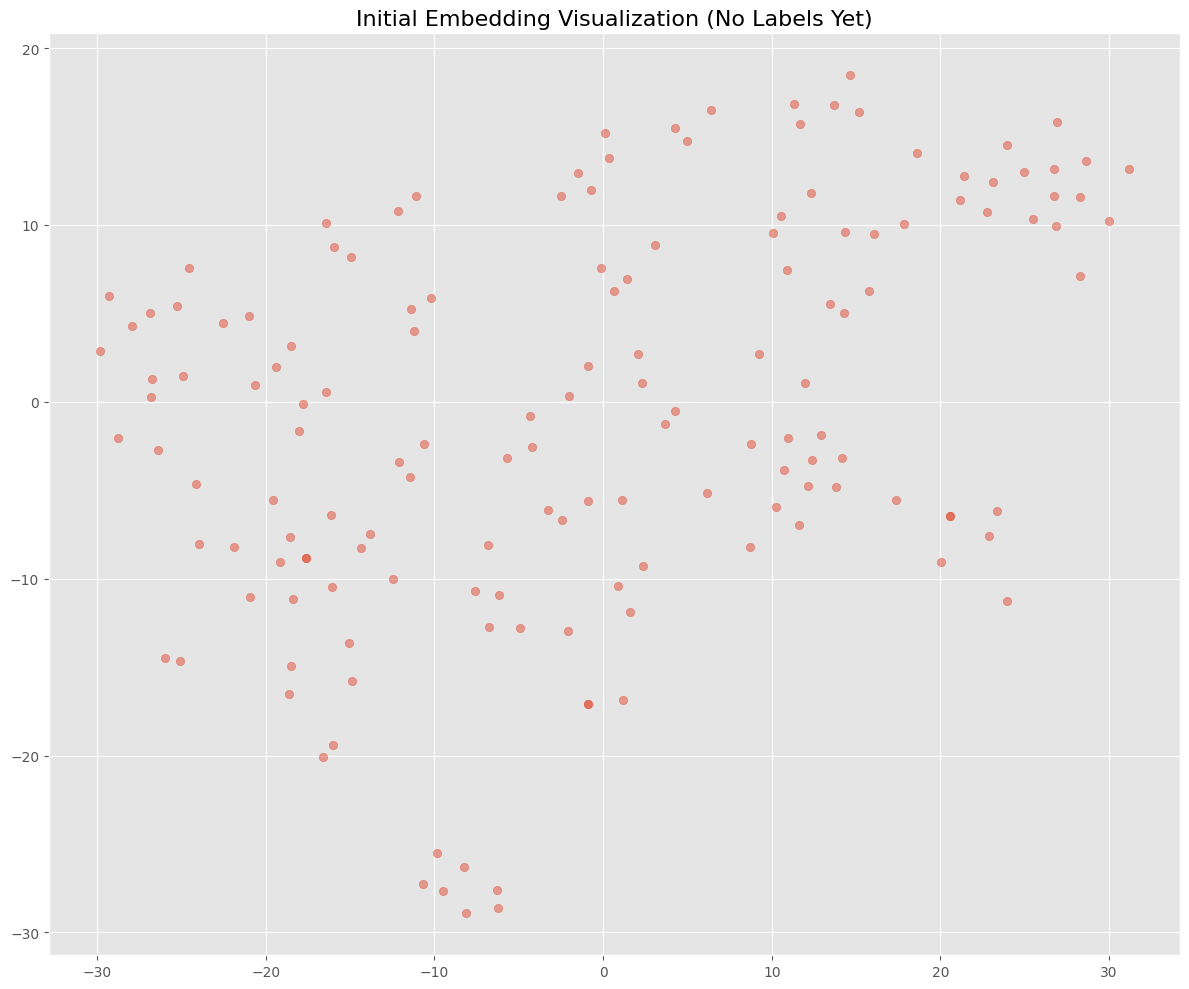

In [22]:
# Cell 3: Initial Visualization of Embeddings

def visualize_embeddings(df, color_by=None, title=None):
    """
    Create a t-SNE visualization of the embeddings.
    
    Args:
        df: DataFrame with embeddings
        color_by: Column name to use for coloring points (e.g., 'true_label')
        title: Custom title for the plot
    """
    # Extract embeddings
    embeddings = np.vstack(df["embedding"].values)
    
    # Reduce dimensions with t-SNE
    print("Calculating t-SNE projection (this may take a moment)...")
    tsne = TSNE(n_components=2, perplexity=15, random_state=42)
    reduced_data = tsne.fit_transform(embeddings)
    
    # Create plot
    plt.figure(figsize=(12, 10))
    
    # If we have labels, color by them
    if color_by and color_by in df.columns and df[color_by].notna().any():
        # Get unique labels
        labels = df[color_by].fillna("Unlabeled").unique()
        
        # Create a colormap
        import matplotlib.cm as cm
        colors = cm.rainbow(np.linspace(0, 1, len(labels)))
        
        # Plot each label group
        for i, label in enumerate(labels):
            mask = df[color_by].fillna("Unlabeled") == label
            plt.scatter(
                reduced_data[mask, 0], 
                reduced_data[mask, 1],
                label=label, 
                color=colors[i],
                alpha=0.7,
                s=80
            )
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        # Plot all points with same color
        plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.5)
    
    # Set title
    if title:
        plt.title(title, fontsize=16)
    else:
        plt.title("t-SNE Visualization of Census Variable Embeddings", fontsize=16)
    
    plt.tight_layout()
    plt.show()
    
# Visualize the unlabeled embeddings
visualize_embeddings(df, title="Initial Embedding Visualization (No Labels Yet)")

# LAB NOTES: Visualizing Embeddings

## What Are We Looking At?
1. This is a t-SNE visualization that projects our 384-dimensional vectors into 2D space
2. Each point represents one Census variable
3. The closer two points are, the more similar their descriptions
4. We can see clusters starting to form naturally

## t-SNE Visualization:
* t-SNE preserves local relationships - points that are close in 384 dimensions should be close in 2D
* The exact positions aren't meaningful, but the relative distances between nearby points are
* This gives us a sense of how our data clusters before we add any labels

## Discussion Points:
* Do you see any natural clusters forming?
* Why might certain variables be grouped together?
* How could this help with the classification task?

**Note**: that we're now ready to start labeling some of these variables to train our classifier.

## Step 4 Note:
This Step 4 below only defines the functions - it doesn't actually start the labeling process yet.
The actual labeling will begin when we run Step 5 in the next cell where we call `label_items_cli(df, n=10)`.

In [28]:
# Step 4: Define Labeling Scheme and Functions

label_map = {
    "1": "Income & Earnings",
    "2": "Housing & Households",
    "3": "Poverty & Economic Hardship",
    "4": "Education & Schooling",
    "5": "Demographics",
    "6": "Healthcare & Insurance",
    "7": "Occupation & Employment",
    "8": "Transportation & Commuting",
    "9": "Internet & Technology",
    "10": "Immigration & Nativity",
    "11": "Language",
    "12": "Disability Status",
    "13": "Veteran Status",
    "14": "Family Composition",
    "15": "Geographic Mobility",
    "16": "Other"
}

def display_labeling_progress(df):
    """Show the current labeling progress."""
    total = len(df)
    labeled = df["true_label"].notna().sum()
    predicted = df[df["predicted_label"].notna() & df["true_label"].isna()].shape[0]
    unlabeled = df[df["true_label"].isna() & df["predicted_label"].isna()].shape[0]
    
    # Create a horizontal bar chart
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.barh(["Progress"], [labeled], color="green", label=f"Human Labeled ({labeled})")
    ax.barh(["Progress"], [predicted], left=[labeled], color="orange", 
            label=f"Model Predicted ({predicted})")
    ax.barh(["Progress"], [unlabeled], left=[labeled+predicted], color="lightgray", 
            label=f"Unlabeled ({unlabeled})")
    
    # Add percentage
    for i, v in enumerate([labeled, predicted, unlabeled]):
        if v > 0:
            if i == 0:
                ax.text(v/2, 0, f"{v/total*100:.1f}%", 
                        ha='center', va='center', color='white', fontweight='bold')
            elif i == 1:
                ax.text(labeled + v/2, 0, f"{v/total*100:.1f}%", 
                        ha='center', va='center', color='black', fontweight='bold')
            else:
                ax.text(labeled + predicted + v/2, 0, f"{v/total*100:.1f}%", 
                        ha='center', va='center', color='black', fontweight='bold')
    
    ax.set_xlim(0, total)
    ax.set_title(f"Labeling Progress: {labeled}/{total} items labeled")
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    plt.tight_layout()
    plt.show()

def label_items_cli(df, n=5):
    """
    Ask the user (in the notebook) to label n random items that do NOT yet have a 'true_label'.
    """
    df_unlabeled = df[df["true_label"].isna()]
    if df_unlabeled.empty:
        print("All items have a true_label. No labeling needed.")
        return df
    
    sample = df_unlabeled.sample(min(n, len(df_unlabeled)))
    
    print("\nAssign a number for each Census variable:")
    for k,v in label_map.items():
        print(f"{k}: {v}")
    print("Or type 'skip' to leave it unlabeled, or just Enter to skip.\n")
    
    for idx, row in sample.iterrows():
        print("-"*80)
        print(f"ID: {row['id']}")
        print(f"Description: {row['description']}")
        print(f"Concept: {row['concept']}")
        user_input = input("Label number? ")
        if user_input.lower() == "skip" or user_input.strip() == "":
            continue
        if user_input in label_map:
            chosen_label = label_map[user_input]
            df.at[idx, "true_label"] = chosen_label
            print(f"  => [true_label = '{chosen_label}']")
        else:
            print("Invalid input. Skipped.")
    
    # Show current labeling progress
    display_labeling_progress(df)
    return df

def correct_predictions_cli(df, n=5):
    """
    Randomly sample n items that have a predicted_label but no confirmed label yet,
    and ask user if it's correct. If not, user picks a new label.
    """
    df_pred = df[(df["predicted_label"].notna()) & (df["true_label"].isna())]
    if df_pred.empty:
        print("No items with predictions to correct. Did you predict or do we have them all labeled?")
        return df, 0
    
    # Sort by confidence (lowest first) if available
    if "confidence" in df_pred.columns and df_pred["confidence"].notna().any():
        sample = df_pred.sort_values("confidence").head(min(n, len(df_pred)))
        print("\nShowing the lowest-confidence predictions first:")
    else:
        sample = df_pred.sample(min(n, len(df_pred)))
        print("\nShowing random predictions:")
    
    print("\nCheck the model's predictions. If correct, press Enter; otherwise, type a new number.")
    for k,v in label_map.items():
        print(f"{k}: {v}")
    print("Type 'skip' to leave it unlabeled.\n")
    
    corrections = 0
    for idx, row in sample.iterrows():
        print("-"*80)
        print(f"ID: {row['id']}")
        print(f"Description: {row['description']}")
        print(f"Concept: {row['concept']}")
        confidence_str = f" (confidence: {row['confidence']:.2f})" if "confidence" in row and pd.notna(row["confidence"]) else ""
        print(f"Predicted label = '{row['predicted_label']}'{confidence_str}")
        user_input = input("Is this correct? If not, type new label #. ")
        if user_input.lower() == "skip":
            continue
        if user_input.strip() == "":
            # user accepts the predicted label
            df.at[idx, "true_label"] = row["predicted_label"]
        elif user_input in label_map:
            new_label = label_map[user_input]
            df.at[idx, "true_label"] = new_label
            if new_label != row["predicted_label"]:
                corrections += 1
            print(f"  => [true_label = '{new_label}']")
        else:
            print("Invalid input. Skipped.")
    
    print(f"\n=> Number of corrections made: {corrections}")
    # Show current labeling progress
    display_labeling_progress(df)
    return df, corrections

# LAB NOTES: Interactive Labeling

## In this section:
1. We define a labeling scheme for Census variables
2. We create interactive functions for:
   - Labeling new items
   - Correcting model predictions
   - Tracking progress

## About the Categories:
The categories we're using are based on common Census variable types:
- **Income & Earnings**: Variables related to personal/household income, earnings, wages, salaries
- **Housing & Households**: Variables related to home values, ownership, rent, housing characteristics
- **Poverty & Economic Hardship**: Variables related to economic hardship, poverty thresholds, assistance programs
- **Education & Schooling**: Variables related to schooling, attendance, attainment, degrees
- **Demographics**: Variables related to age, sex, race, ethnicity, ancestry
- **Healthcare & Insurance**: Variables related to health coverage, medical access, healthcare utilization
- **Occupation & Employment**: Variables related to labor force, jobs, work status, industry
- **Transportation & Commuting**: Variables related to travel to work, vehicles, commuting patterns
- **Internet & Technology**: Variables related to computer usage, broadband access, digital connectivity
- **Immigration & Nativity**: Variables related to place of birth, citizenship, foreign-born status
- **Language**: Variables related to language spoken at home, English proficiency, linguistic isolation
- **Disability Status**: Variables related to disability types, limitations, accommodations
- **Veteran Status**: Variables related to military service, period of service, veteran benefits
- **Family Composition**: Variables related to family type, household structure, parent-child relationships
- **Geographic Mobility**: Variables related to migration, relocation, residential mobility
- **Other**: Variables that don't fit clearly into the above categories

***(See Appendix A1 for detailed category definitions and classification guidance)***


## Labeling Tips:
- While labeling, sometimes it helps to discuss and explain your reasoning, not every case will be clear
- Discuss ambiguous cases (e.g., "Income by Educational Attainment")
- Check out how the progress bar shows our labeling status

## Let's Create some labels!

Let's start by labeling 10 random Census variables:

Assign a number for each Census variable:
1: Income & Earnings
2: Housing & Households
3: Poverty & Economic Hardship
4: Education & Schooling
5: Demographics
6: Healthcare & Insurance
7: Occupation & Employment
8: Transportation & Commuting
9: Internet & Technology
10: Immigration & Nativity
11: Language
12: Disability Status
13: Veteran Status
14: Family Composition
15: Geographic Mobility
16: Other
Or type 'skip' to leave it unlabeled, or just Enter to skip.

--------------------------------------------------------------------------------
ID: B08130_009E
Description: Estimate!!Total:!!Car, truck, or van - drove alone:!!Worked in state of residence:!!Worked outside county of residence
Concept: MEANS OF TRANSPORTATION TO WORK BY PLACE OF WORK--STATE AND COUNTY LEVEL


Label number?  8


  => [true_label = 'Transportation & Commuting']
--------------------------------------------------------------------------------
ID: B24115_133E
Description: Estimate!!Total:!!Substance abuse and behavioral disorder counselors
Concept: DETAILED OCCUPATION FOR THE CIVILIAN EMPLOYED MALE POPULATION 16 YEARS AND OVER


Label number?  7


  => [true_label = 'Occupation & Employment']
--------------------------------------------------------------------------------
ID: B26110_016E
Description: Estimate!!Total:!!Group quarters population:!!Native:!!Male
Concept: GROUP QUARTERS TYPE (3 TYPES) BY NATIVITY AND CITIZENSHIP STATUS BY SEX


Label number?  2


  => [true_label = 'Housing & Households']
--------------------------------------------------------------------------------
ID: B24126_202E
Description: Estimate!!Total:!!Pharmacists
Concept: DETAILED OCCUPATION FOR THE FULL-TIME, YEAR-ROUND CIVILIAN EMPLOYED FEMALE POPULATION 16 YEARS AND OVER


Label number?  7


  => [true_label = 'Occupation & Employment']
--------------------------------------------------------------------------------
ID: B15001_040E
Description: Estimate!!Total:!!Male:!!65 years and over:!!Associate's degree
Concept: SEX BY AGE BY EDUCATIONAL ATTAINMENT FOR THE POPULATION 18 YEARS AND OVER


Label number?  4


  => [true_label = 'Education & Schooling']
--------------------------------------------------------------------------------
ID: B05006_112E
Description: Estimate!!Total:!!Africa:!!Southern Africa:!!Other Southern Africa
Concept: PLACE OF BIRTH FOR THE FOREIGN-BORN POPULATION IN THE UNITED STATES


Label number?  5


  => [true_label = 'Demographics']
--------------------------------------------------------------------------------
ID: B24136_116E
Description: Estimate!!Total!!Farm supplies merchant wholesalers
Concept: DETAILED INDUSTRY FOR THE CIVILIAN EMPLOYED FEMALE POPULATION 16 YEARS AND OVER


Label number?  7


  => [true_label = 'Occupation & Employment']
--------------------------------------------------------------------------------
ID: B02014_044E
Description: Estimate!!Total:!!American Indian tribes, specified:!!All other American Indian tribes (with only one tribe reported)
Concept: AMERICAN INDIAN AND ALASKA NATIVE ALONE FOR SELECTED TRIBAL GROUPINGS


Label number?  5


  => [true_label = 'Demographics']
--------------------------------------------------------------------------------
ID: B15003_014E
Description: Estimate!!Total:!!10th grade
Concept: EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER


Label number?  4


  => [true_label = 'Education & Schooling']
--------------------------------------------------------------------------------
ID: B24116_161E
Description: Estimate!!Total:!!Other teachers and instructors
Concept: DETAILED OCCUPATION FOR THE CIVILIAN EMPLOYED FEMALE POPULATION 16 YEARS AND OVER


Label number?  7


  => [true_label = 'Occupation & Employment']


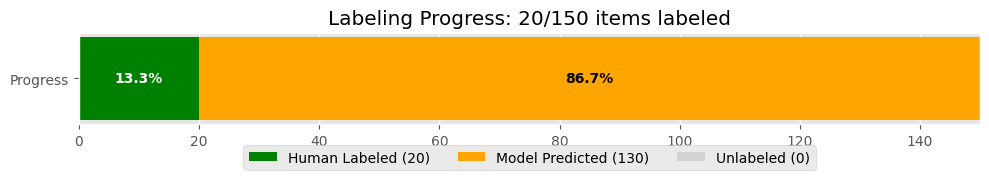

In [29]:
# Step 5: Initial Labeling

print("Let's start by labeling 10 random Census variables:")
df = label_items_cli(df, n=10)

# LAB NOTES: Labeling Process

## What Just Happened?
1. We randomly selected 10 Census variables
2. We manually assigned categories to them
3. This gives us an initial training set

## Discussion Points:
* How easy or difficult was it to assign categories?
* Were there any variables that could fit multiple categories?
* How consistent do you think different people would be in labeling?

## Real-World Context:
In federal agencies, this labeling process would typically involve:
- Subject matter experts (SMEs) who understand the data
- Data scientists who understand the modeling approach
- Iterative refinement of the labeling scheme

The quality of these initial labels is crucial because they form the foundation
for our model's understanding of the categories.

In [30]:
# Step 6: Train and Predict Function

def train_knn_and_predict(df):
    """
    Train a KNN classifier on items with true_label and predict for unlabeled items.
    """
    df_labeled = df[df["true_label"].notna()]
    if df_labeled.empty:
        print("No training data (true_label) available. Cannot train.")
        return df
    
    X_train = np.vstack(df_labeled["embedding"].values)
    y_train = df_labeled["true_label"].values
    
    # Create and train the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    print(f"Trained KNN classifier on {len(df_labeled)} labeled items.")
    
    # Get label distribution in training data
    label_counts = pd.Series(y_train).value_counts()
    print("\nLabel distribution in training data:")
    for label, count in label_counts.items():
        print(f"  {label}: {count} items ({count/len(y_train)*100:.1f}%)")
    
    # Predict for items that have no true_label
    df_unlabeled = df[df["true_label"].isna()]
    if len(df_unlabeled) == 0:
        print("No unlabeled items left to predict.")
        return df
    
    X_unlabeled = np.vstack(df_unlabeled["embedding"].values)
    preds = knn.predict(X_unlabeled)
    
    # Calculate confidence scores
    distances, indices = knn.kneighbors(X_unlabeled)
    # Convert distances to confidence (inverse of avg distance)
    confidence = 1 / (distances.mean(axis=1) + 0.001)  # Add small constant to avoid division by zero
    # Normalize confidence to 0-1 scale
    confidence = (confidence - confidence.min()) / (confidence.max() - confidence.min() + 0.001)
    
    # Update dataframe with predictions and confidence
    df.loc[df_unlabeled.index, "predicted_label"] = preds
    df.loc[df_unlabeled.index, "confidence"] = confidence
    
    print(f"Predicted labels for {len(df_unlabeled)} unlabeled Census variables.")
    
    return df

# Train our first model and make predictions
df = train_knn_and_predict(df)

Trained KNN classifier on 20 labeled items.

Label distribution in training data:
  Demographics: 4 items (20.0%)
  Occupation & Employment: 4 items (20.0%)
  Other: 3 items (15.0%)
  Income: 3 items (15.0%)
  Education & Schooling: 2 items (10.0%)
  Education: 1 items (5.0%)
  Housing & Households: 1 items (5.0%)
  Transportation & Commuting: 1 items (5.0%)
  Housing: 1 items (5.0%)
Predicted labels for 130 unlabeled Census variables.


# LAB NOTES: KNN Classification with Embeddings

## What Just Happened?
1. We trained a k-Nearest Neighbors (KNN) classifier on our labeled data
2. The classifier found the 3 most similar labeled items for each unlabeled item
3. It assigned the most common label among those neighbors
4. We also calculated a confidence score based on how close the neighbors are

## How KNN Works:
* It's a simple but effective algorithm for this task
* It finds the k closest points in our embedding space
* It uses majority voting among those neighbors
* No complex training process - just storing the labeled examples

## Confidence Scores:
* Higher confidence = the neighbors are very close in embedding space
* Lower confidence = the neighbors are farther away
* We'll use these scores to prioritize which predictions to check

## Discussion Points:
* Look at the label distribution - is it balanced?
* What might happen if some categories have very few examples?
* How might we decide on the right value of k (neighbors)?

Let's check 5 predictions from the model:

Showing the lowest-confidence predictions first:

Check the model's predictions. If correct, press Enter; otherwise, type a new number.
1: Income & Earnings
2: Housing & Households
3: Poverty & Economic Hardship
4: Education & Schooling
5: Demographics
6: Healthcare & Insurance
7: Occupation & Employment
8: Transportation & Commuting
9: Internet & Technology
10: Immigration & Nativity
11: Language
12: Disability Status
13: Veteran Status
14: Family Composition
15: Geographic Mobility
16: Other
Type 'skip' to leave it unlabeled.

--------------------------------------------------------------------------------
ID: B24116_431E
Description: Estimate!!Total:!!Explosives workers, ordnance handling experts, and blasters
Concept: DETAILED OCCUPATION FOR THE CIVILIAN EMPLOYED FEMALE POPULATION 16 YEARS AND OVER
Predicted label = 'Housing' (confidence: 0.00)


Is this correct? If not, type new label #.  7


  => [true_label = 'Occupation & Employment']
--------------------------------------------------------------------------------
ID: B08134_107E
Description: Estimate!!Total:!!Walked:!!30 to 34 minutes
Concept: MEANS OF TRANSPORTATION TO WORK BY TRAVEL TIME TO WORK
Predicted label = 'Education & Schooling' (confidence: 0.02)


Is this correct? If not, type new label #.  8


  => [true_label = 'Transportation & Commuting']
--------------------------------------------------------------------------------
ID: B06001PR_020E
Description: Estimate!!Total:!!Born in Puerto Rico:!!55 to 59 years
Concept: PLACE OF BIRTH BY AGE IN PUERTO RICO
Predicted label = 'Education & Schooling' (confidence: 0.04)


Is this correct? If not, type new label #.  5


  => [true_label = 'Demographics']
--------------------------------------------------------------------------------
ID: B19082_003E
Description: Estimate!!Quintile Share of Aggregate Income:!!Third Quintile
Concept: SHARES OF AGGREGATE HOUSEHOLD INCOME BY QUINTILE
Predicted label = 'Housing' (confidence: 0.05)


Is this correct? If not, type new label #.  


--------------------------------------------------------------------------------
ID: B17025_005E
Description: Estimate!!Total:!!Income in the past 12 months below poverty level:!!Native:!!Born outside the United States
Concept: POVERTY STATUS IN THE PAST 12 MONTHS BY NATIVITY
Predicted label = 'Demographics' (confidence: 0.05)


Is this correct? If not, type new label #.  10


  => [true_label = 'Immigration & Nativity']

=> Number of corrections made: 4


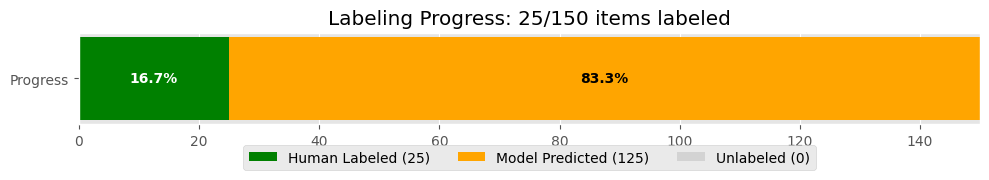

Error rate in this sample: 0.80


In [31]:
# Step 7: Check Some Predictions

print("Let's check 5 predictions from the model:")
df, corrections = correct_predictions_cli(df, n=5)
print(f"Error rate in this sample: {corrections/5:.2f}")

# LAB NOTES: Evaluating Initial Predictions

## What Just Happened?
1. We looked at 5 predictions from our model
2. We corrected any mistakes we found
3. We calculated an initial error rate

## Error Rate:
* This gives us a baseline of model performance
* With very few training examples, we expect a higher error rate
* As we add more labeled examples, this should improve

## Real-World Application:
In federal statistical agencies, this process helps:
- Identify misclassified variables
- Build confidence in the model
- Determine how much more labeling is needed
- Document the quality of automated classification

## Focus on Lowest Confidence:
* Notice that we prioritized the lowest confidence predictions
* This is an "active learning" approach - focus human effort where it's most needed
* It's more efficient than checking random predictions

Let's visualize our data with the initial labels and predictions:


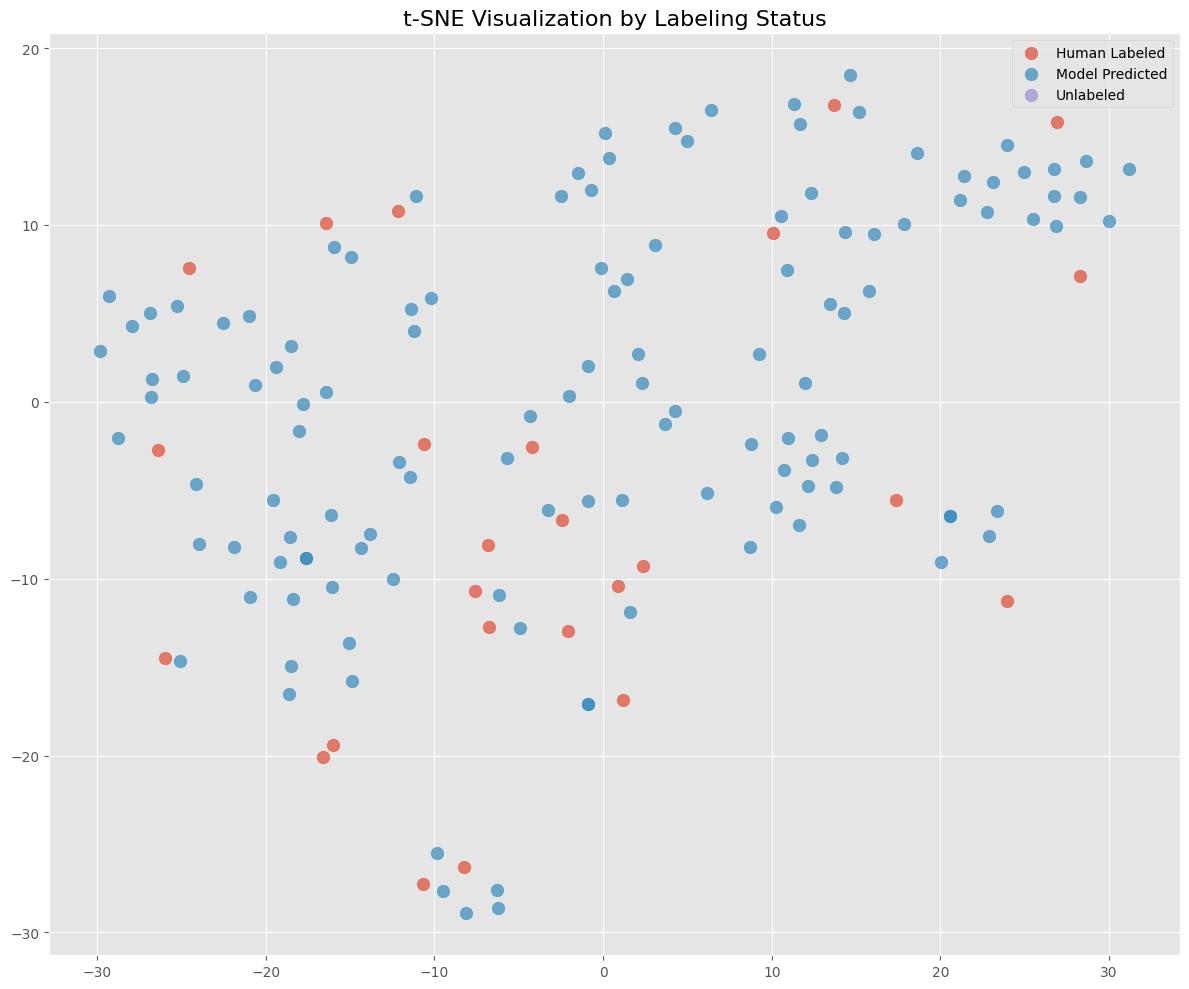

Calculating t-SNE projection (this may take a moment)...


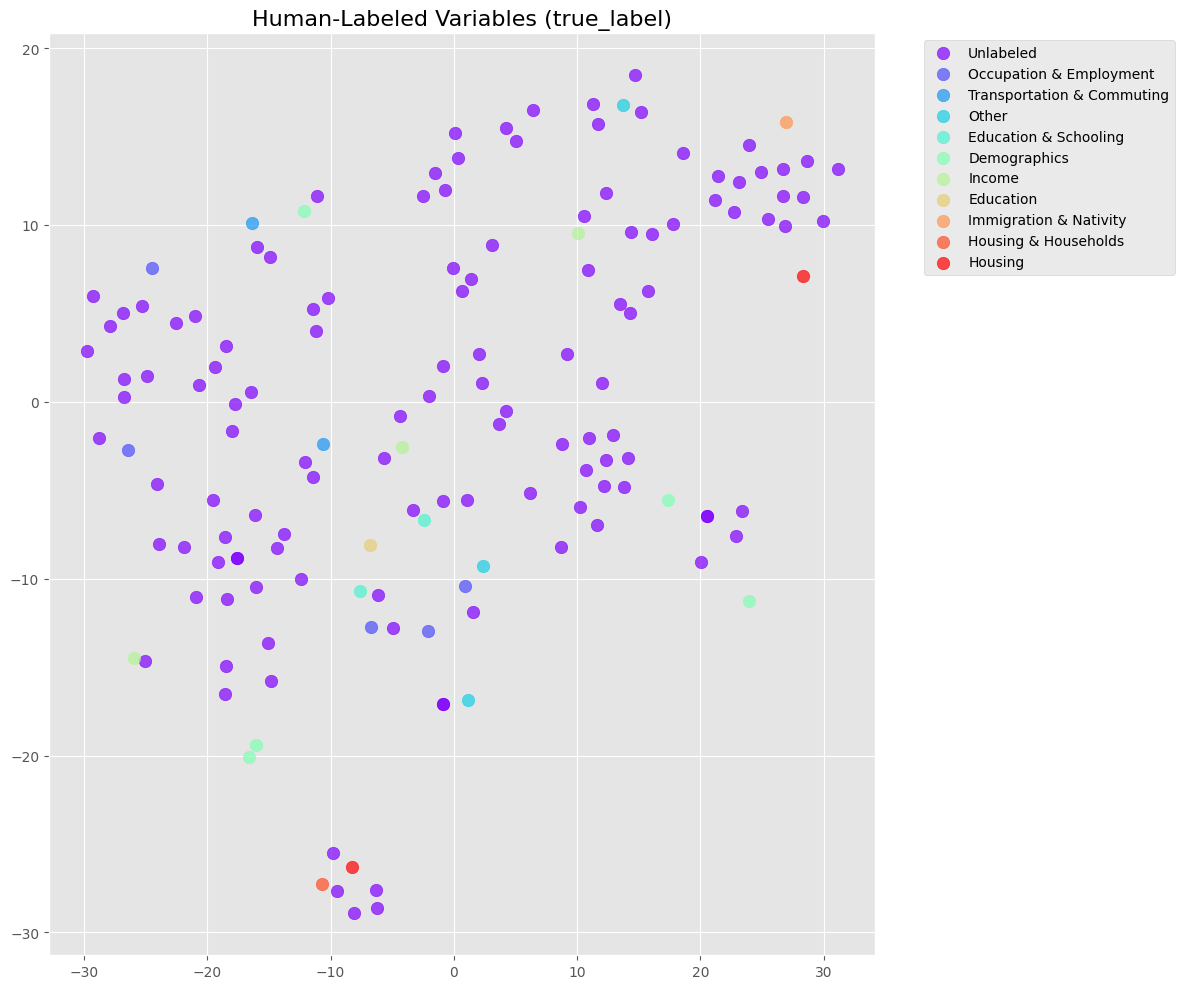

Calculating t-SNE projection (this may take a moment)...


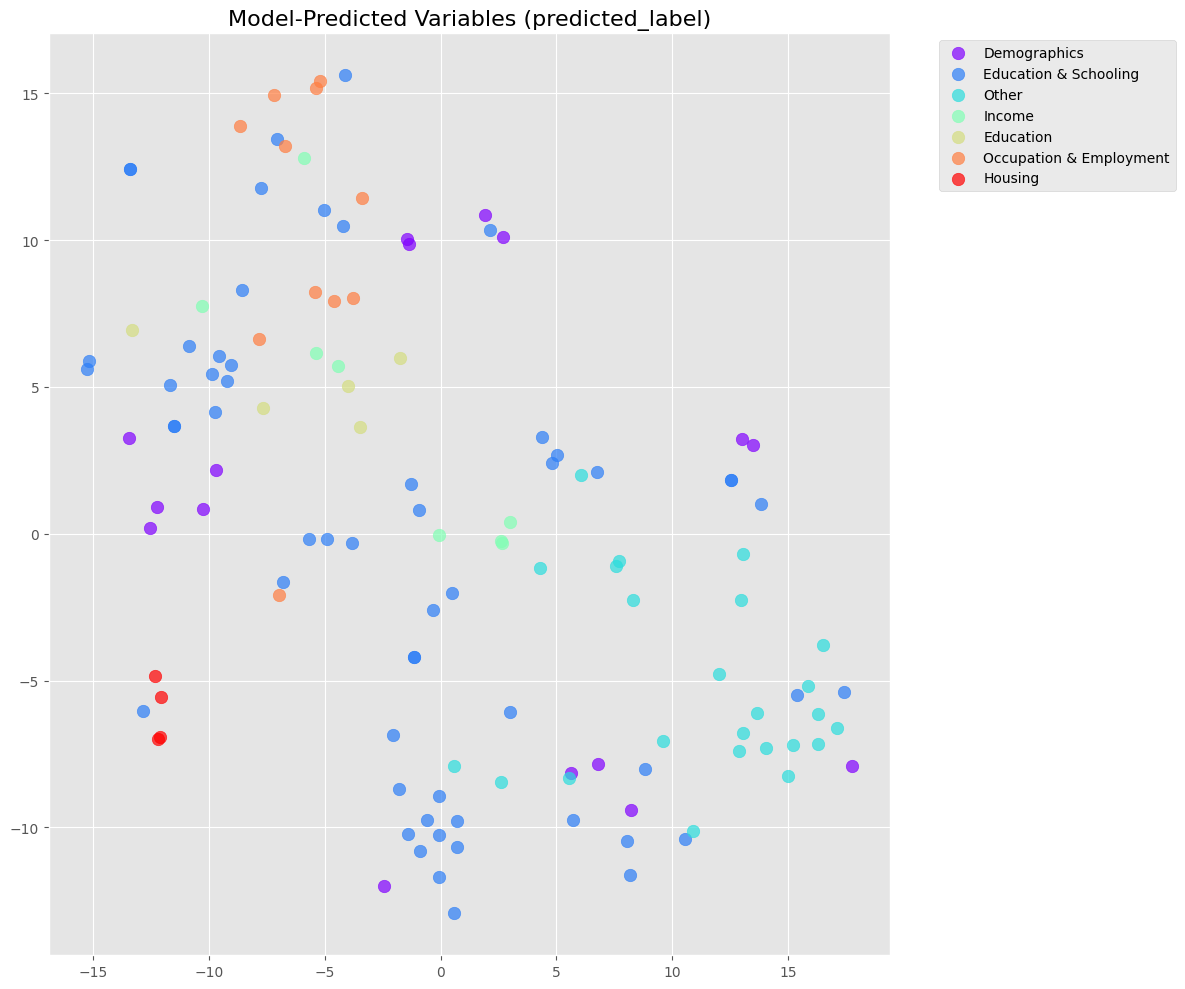

In [32]:
# Step 8: Visualization After Initial Training

print("Let's visualize our data with the initial labels and predictions:")
df_with_labels = df.copy()
df_with_labels["label_status"] = "Unlabeled"
df_with_labels.loc[df["true_label"].notna(), "label_status"] = "Human Labeled"
df_with_labels.loc[(df["true_label"].isna()) & (df["predicted_label"].notna()), "label_status"] = "Model Predicted"

# First visualize by label status
plt.figure(figsize=(12, 10))
embeddings = np.vstack(df_with_labels["embedding"].values)
tsne = TSNE(n_components=2, perplexity=15, random_state=42)
reduced_data = tsne.fit_transform(embeddings)

# Plot different label statuses
for status, color in zip(["Human Labeled", "Model Predicted", "Unlabeled"], ["green", "orange", "lightgray"]):
    mask = df_with_labels["label_status"] == status
    plt.scatter(
        reduced_data[mask, 0], 
        reduced_data[mask, 1],
        label=status, 
        alpha=0.7,
        s=80
    )
plt.title("t-SNE Visualization by Labeling Status", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

# Then visualize by actual labels/predictions
visualize_embeddings(df, color_by="true_label", title="Human-Labeled Variables (true_label)")
visualize_embeddings(df_with_labels[df_with_labels["label_status"] == "Model Predicted"], 
                    color_by="predicted_label", 
                    title="Model-Predicted Variables (predicted_label)")

# LAB NOTES: Visualizing After Initial Labeling

## What We Can Observe:
1. The first plot shows which items are human-labeled vs. model-predicted
2. The second plot shows the distribution of our human-assigned labels
3. The third plot shows how the model has predicted the remaining items

## Discussion Points:
* Can you see clusters forming for specific categories?
* Are the model's predictions forming coherent clusters?
* Are there areas where labels seem mixed or confused?

## Teaching Moment:
This visualization helps us understand:
- How well our embedding space aligns with our chosen categories
- Whether our labels are consistent
- Where the model might be making mistakes

This is a great opportunity to discuss how we might revise our 
labeling scheme if we see issues or inconsistencies.

In [34]:
# Step 9: Iterative Improvement Process

# Set up a list to track our iteration stats
iteration_stats = []

def run_iteration(df, iteration_id, label_count=5, correction_count=5):
    """
    1. Label 'label_count' items from scratch (they have no true_label).
    2. Train & predict for the rest.
    3. Correct 'correction_count' predicted items, measure how many were wrong.
    4. Store iteration stats.
    """
    global iteration_stats
    
    print(f"\n=== Iteration {iteration_id} ===")
    # Step 1: Label new items
    df = label_items_cli(df, n=label_count)
    
    # Step 2: Train & predict
    df = train_knn_and_predict(df)
    
    # Step 3: Correct a sample of predicted items
    df, corrections = correct_predictions_cli(df, n=correction_count)
    
    # Measure error rate
    error_rate = 0
    if correction_count > 0:
        error_rate = corrections / correction_count
    
    # Store stats
    num_labeled = df["true_label"].notna().sum()
    iteration_stats.append({
        "iteration": iteration_id,
        "new_labeled": label_count,
        "corrected_sample": correction_count,
        "corrections_made": corrections,
        "error_rate": error_rate,
        "total_labeled_so_far": num_labeled
    })
    
    print(f"Iteration {iteration_id} => error rate in correction sample: {error_rate:.2f}")
    return df

# LAB NOTES: Iterative Improvement

## What We'll Do Next:
1. Run multiple iterations of our train-predict-correct cycle
2. Track the error rate at each iteration
3. Watch how the model improves as we add more labeled data

## This Process Models Real-World ML Development:
* Start with a small set of labeled data
* Train an initial model
* Use the model to assist with more labeling
* Correct the model's mistakes
* Retrain and repeat

## Active Learning Concept:
This approach is called "active learning" because:
- The model actively participates in its own training
- We focus human effort on the most uncertain predictions
- It's more efficient than randomly labeling data

## Teaching Objective:
Unsderstand the goal: This is continuous improvement. This model building is iterative,
not a one-time process. 


=== Iteration 1 ===

Assign a number for each Census variable:
1: Income & Earnings
2: Housing & Households
3: Poverty & Economic Hardship
4: Education & Schooling
5: Demographics
6: Healthcare & Insurance
7: Occupation & Employment
8: Transportation & Commuting
9: Internet & Technology
10: Immigration & Nativity
11: Language
12: Disability Status
13: Veteran Status
14: Family Composition
15: Geographic Mobility
16: Other
Or type 'skip' to leave it unlabeled, or just Enter to skip.

--------------------------------------------------------------------------------
ID: B04004_002E
Description: Estimate!!Total:!!Afghan
Concept: PEOPLE REPORTING SINGLE ANCESTRY


Label number?  10


  => [true_label = 'Immigration & Nativity']
--------------------------------------------------------------------------------
ID: B06004C_002E
Description: Estimate!!Total:!!Born in state of residence
Concept: PLACE OF BIRTH (AMERICAN INDIAN AND ALASKA NATIVE ALONE) IN THE UNITED STATES


Label number?  10


  => [true_label = 'Immigration & Nativity']
--------------------------------------------------------------------------------
ID: B08412_023E
Description: Estimate!!Total:!!Male:!!40 to 44 minutes
Concept: SEX OF WORKERS BY TRAVEL TIME TO WORK FOR WORKPLACE GEOGRAPHY


Label number?  8


  => [true_label = 'Transportation & Commuting']
--------------------------------------------------------------------------------
ID: B25095_048E
Description: Estimate!!Total:!!$75,000 to $99,999:!!Less than 20.0 percent
Concept: HOUSEHOLD INCOME BY SELECTED MONTHLY OWNER COSTS AS A PERCENTAGE OF HOUSEHOLD INCOME IN THE PAST 12 MONTHS


Label number?  1


  => [true_label = 'Income & Earnings']
--------------------------------------------------------------------------------
ID: B08532_086E
Description: Estimate!!Total:!!Taxicab, motorcycle, bicycle, or other means:!!9:00 a.m. to 9:59 a.m.
Concept: MEANS OF TRANSPORTATION TO WORK BY TIME ARRIVING AT WORK FOR WORKPLACE GEOGRAPHY


Label number?  8


  => [true_label = 'Transportation & Commuting']


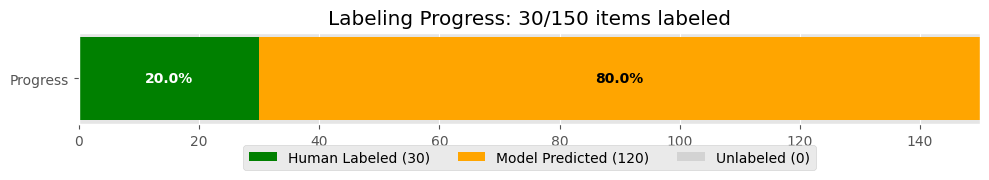

Trained KNN classifier on 30 labeled items.

Label distribution in training data:
  Occupation & Employment: 5 items (16.7%)
  Demographics: 5 items (16.7%)
  Transportation & Commuting: 4 items (13.3%)
  Immigration & Nativity: 3 items (10.0%)
  Other: 3 items (10.0%)
  Income: 3 items (10.0%)
  Education & Schooling: 2 items (6.7%)
  Housing: 2 items (6.7%)
  Income & Earnings: 1 items (3.3%)
  Education: 1 items (3.3%)
  Housing & Households: 1 items (3.3%)
Predicted labels for 120 unlabeled Census variables.

Showing the lowest-confidence predictions first:

Check the model's predictions. If correct, press Enter; otherwise, type a new number.
1: Income & Earnings
2: Housing & Households
3: Poverty & Economic Hardship
4: Education & Schooling
5: Demographics
6: Healthcare & Insurance
7: Occupation & Employment
8: Transportation & Commuting
9: Internet & Technology
10: Immigration & Nativity
11: Language
12: Disability Status
13: Veteran Status
14: Family Composition
15: Geographic M

Is this correct? If not, type new label #.  2


  => [true_label = 'Housing & Households']
--------------------------------------------------------------------------------
ID: B24115_527E
Description: Estimate!!Total:!!Etchers and engravers
Concept: DETAILED OCCUPATION FOR THE CIVILIAN EMPLOYED MALE POPULATION 16 YEARS AND OVER
Predicted label = 'Education' (confidence: 0.04)


Is this correct? If not, type new label #.  7


  => [true_label = 'Occupation & Employment']
--------------------------------------------------------------------------------
ID: B24116_454E
Description: Estimate!!Total:!!Heating, air conditioning, and refrigeration mechanics and installers
Concept: DETAILED OCCUPATION FOR THE CIVILIAN EMPLOYED FEMALE POPULATION 16 YEARS AND OVER
Predicted label = 'Education & Schooling' (confidence: 0.04)


Is this correct? If not, type new label #.  7


  => [true_label = 'Occupation & Employment']
--------------------------------------------------------------------------------
ID: B24125_528E
Description: Estimate!!Total:!!Molders, shapers, and casters, except metal and plastic
Concept: DETAILED OCCUPATION FOR THE FULL-TIME, YEAR-ROUND CIVILIAN EMPLOYED MALE POPULATION 16 YEARS AND OVER
Predicted label = 'Occupation & Employment' (confidence: 0.05)


Is this correct? If not, type new label #.  7


  => [true_label = 'Occupation & Employment']
--------------------------------------------------------------------------------
ID: B99221_002E
Description: Estimate!!Total:!!Allocated
Concept: ALLOCATION OF FOOD STAMPS/SNAP RECEIPT
Predicted label = 'Education & Schooling' (confidence: 0.07)


Is this correct? If not, type new label #.  3


  => [true_label = 'Poverty & Economic Hardship']

=> Number of corrections made: 4


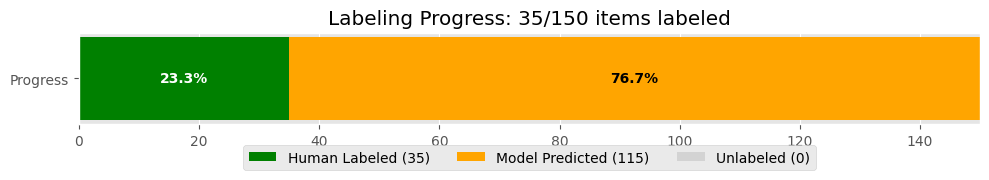

Iteration 1 => error rate in correction sample: 0.80

=== Iteration 2 ===

Assign a number for each Census variable:
1: Income & Earnings
2: Housing & Households
3: Poverty & Economic Hardship
4: Education & Schooling
5: Demographics
6: Healthcare & Insurance
7: Occupation & Employment
8: Transportation & Commuting
9: Internet & Technology
10: Immigration & Nativity
11: Language
12: Disability Status
13: Veteran Status
14: Family Composition
15: Geographic Mobility
16: Other
Or type 'skip' to leave it unlabeled, or just Enter to skip.

--------------------------------------------------------------------------------
ID: B20005B_080E
Description: Estimate!!Total:!!Female:!!Other:!!With earnings:!!$10,000 to $12,499
Concept: SEX BY WORK EXPERIENCE IN THE PAST 12 MONTHS BY EARNINGS IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS) FOR THE POPULATION 16 YEARS AND OVER (BLACK OR AFRICAN AMERICAN ALONE)


Label number?  5


  => [true_label = 'Demographics']
--------------------------------------------------------------------------------
ID: B24115_468E
Description: Estimate!!Total:!!Riggers
Concept: DETAILED OCCUPATION FOR THE CIVILIAN EMPLOYED MALE POPULATION 16 YEARS AND OVER


Label number?  7


  => [true_label = 'Occupation & Employment']
--------------------------------------------------------------------------------
ID: B17010H_037E
Description: Estimate!!Total:!!Income in the past 12 months at or above poverty level:!!Other family:!!Female householder, no spouse present:!!With related children of the householder under 18 years:
Concept: POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILIES BY FAMILY TYPE BY PRESENCE OF RELATED CHILDREN UNDER 18 YEARS BY AGE OF RELATED CHILDREN (WHITE ALONE, NOT HISPANIC OR LATINO HOUSEHOLDER)


Label number?  3


  => [true_label = 'Poverty & Economic Hardship']
--------------------------------------------------------------------------------
ID: B05006_166E
Description: Estimate!!Total:!!Americas:!!Northern America:
Concept: PLACE OF BIRTH FOR THE FOREIGN-BORN POPULATION IN THE UNITED STATES


Label number?  10


  => [true_label = 'Immigration & Nativity']
--------------------------------------------------------------------------------
ID: B19037_054E
Description: Estimate!!Total:!!Householder 65 years and over:!!Less than $10,000
Concept: AGE OF HOUSEHOLDER BY HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS)


Label number?  5


  => [true_label = 'Demographics']


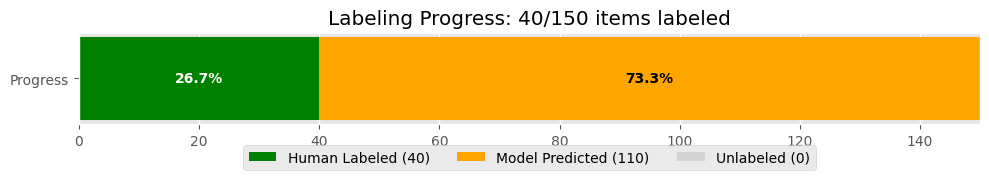

Trained KNN classifier on 40 labeled items.

Label distribution in training data:
  Occupation & Employment: 9 items (22.5%)
  Demographics: 7 items (17.5%)
  Immigration & Nativity: 4 items (10.0%)
  Transportation & Commuting: 4 items (10.0%)
  Other: 3 items (7.5%)
  Income: 3 items (7.5%)
  Education & Schooling: 2 items (5.0%)
  Housing & Households: 2 items (5.0%)
  Housing: 2 items (5.0%)
  Poverty & Economic Hardship: 2 items (5.0%)
  Income & Earnings: 1 items (2.5%)
  Education: 1 items (2.5%)
Predicted labels for 110 unlabeled Census variables.

Showing the lowest-confidence predictions first:

Check the model's predictions. If correct, press Enter; otherwise, type a new number.
1: Income & Earnings
2: Housing & Households
3: Poverty & Economic Hardship
4: Education & Schooling
5: Demographics
6: Healthcare & Insurance
7: Occupation & Employment
8: Transportation & Commuting
9: Internet & Technology
10: Immigration & Nativity
11: Language
12: Disability Status
13: Veteran St

Is this correct? If not, type new label #.  


--------------------------------------------------------------------------------
ID: B23022_009E
Description: Estimate!!Total:!!Male:!!Worked in the past 12 months:!!Usually worked 35 or more hours per week:!!14 to 26 weeks
Concept: SEX BY WORK STATUS IN THE PAST 12 MONTHS BY USUAL HOURS WORKED PER WEEK IN THE PAST 12 MONTHS BY WEEKS WORKED IN THE PAST 12 MONTHS FOR THE POPULATION 16 TO 64 YEARS
Predicted label = 'Education & Schooling' (confidence: 0.01)


Is this correct? If not, type new label #.  7


  => [true_label = 'Occupation & Employment']
--------------------------------------------------------------------------------
ID: B24115_381E
Description: Estimate!!Total:!!Word processors and typists
Concept: DETAILED OCCUPATION FOR THE CIVILIAN EMPLOYED MALE POPULATION 16 YEARS AND OVER
Predicted label = 'Education' (confidence: 0.02)


Is this correct? If not, type new label #.  7


  => [true_label = 'Occupation & Employment']
--------------------------------------------------------------------------------
ID: B23022_005E
Description: Estimate!!Total:!!Male:!!Worked in the past 12 months:!!Usually worked 35 or more hours per week:!!50 to 52 weeks
Concept: SEX BY WORK STATUS IN THE PAST 12 MONTHS BY USUAL HOURS WORKED PER WEEK IN THE PAST 12 MONTHS BY WEEKS WORKED IN THE PAST 12 MONTHS FOR THE POPULATION 16 TO 64 YEARS
Predicted label = 'Education & Schooling' (confidence: 0.02)


Is this correct? If not, type new label #.  7


  => [true_label = 'Occupation & Employment']
--------------------------------------------------------------------------------
ID: B24123_306E
Description: Estimate!!Total:!!Barbers
Concept: DETAILED OCCUPATION BY MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS) FOR THE FULL-TIME, YEAR-ROUND CIVILIAN EMPLOYED FEMALE POPULATION 16 YEARS AND OVER
Predicted label = 'Occupation & Employment' (confidence: 0.02)


Is this correct? If not, type new label #.  



=> Number of corrections made: 3


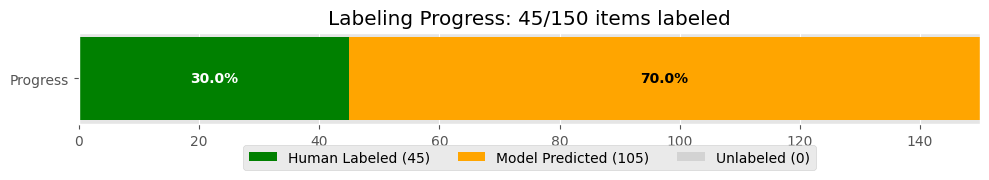

Iteration 2 => error rate in correction sample: 0.60

=== Iteration 3 ===

Assign a number for each Census variable:
1: Income & Earnings
2: Housing & Households
3: Poverty & Economic Hardship
4: Education & Schooling
5: Demographics
6: Healthcare & Insurance
7: Occupation & Employment
8: Transportation & Commuting
9: Internet & Technology
10: Immigration & Nativity
11: Language
12: Disability Status
13: Veteran Status
14: Family Composition
15: Geographic Mobility
16: Other
Or type 'skip' to leave it unlabeled, or just Enter to skip.

--------------------------------------------------------------------------------
ID: B08412_012E
Description: Estimate!!Total:!!60 to 89 minutes
Concept: SEX OF WORKERS BY TRAVEL TIME TO WORK FOR WORKPLACE GEOGRAPHY


Label number?  8


  => [true_label = 'Transportation & Commuting']
--------------------------------------------------------------------------------
ID: B17018_014E
Description: Estimate!!Total:!!Income in the past 12 months below poverty level:!!Other families:!!Female householder, no spouse present:
Concept: POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILIES BY HOUSEHOLD TYPE BY EDUCATIONAL ATTAINMENT OF HOUSEHOLDER


Label number?  3


  => [true_label = 'Poverty & Economic Hardship']
--------------------------------------------------------------------------------
ID: B17020B_007E
Description: Estimate!!Total:!!Income in the past 12 months below poverty level:!!60 to 74 years
Concept: POVERTY STATUS IN THE PAST 12 MONTHS BY AGE (BLACK OR AFRICAN AMERICAN ALONE)


Label number?  3


  => [true_label = 'Poverty & Economic Hardship']
--------------------------------------------------------------------------------
ID: B23027_033E
Description: Estimate!!Total:!!70 years and over:!!Worked in the past 12 months:
Concept: FULL-TIME, YEAR-ROUND WORK STATUS IN THE PAST 12 MONTHS BY AGE FOR THE POPULATION 16 YEARS AND OVER


Label number?  7


  => [true_label = 'Occupation & Employment']
--------------------------------------------------------------------------------
ID: B18101_038E
Description: Estimate!!Total:!!Female:!!75 years and over:!!With a disability
Concept: SEX BY AGE BY DISABILITY STATUS


Label number?  12


  => [true_label = 'Disability Status']


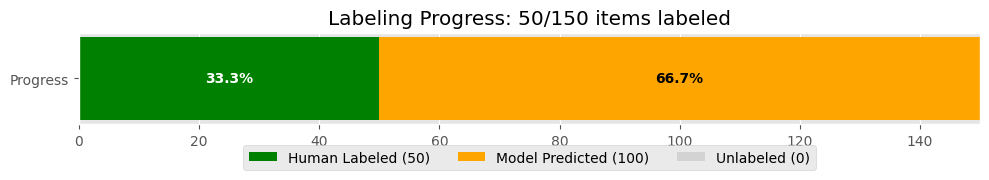

Trained KNN classifier on 50 labeled items.

Label distribution in training data:
  Occupation & Employment: 14 items (28.0%)
  Demographics: 7 items (14.0%)
  Transportation & Commuting: 5 items (10.0%)
  Poverty & Economic Hardship: 4 items (8.0%)
  Immigration & Nativity: 4 items (8.0%)
  Housing: 3 items (6.0%)
  Other: 3 items (6.0%)
  Income: 3 items (6.0%)
  Education & Schooling: 2 items (4.0%)
  Housing & Households: 2 items (4.0%)
  Income & Earnings: 1 items (2.0%)
  Education: 1 items (2.0%)
  Disability Status: 1 items (2.0%)
Predicted labels for 100 unlabeled Census variables.

Showing the lowest-confidence predictions first:

Check the model's predictions. If correct, press Enter; otherwise, type a new number.
1: Income & Earnings
2: Housing & Households
3: Poverty & Economic Hardship
4: Education & Schooling
5: Demographics
6: Healthcare & Insurance
7: Occupation & Employment
8: Transportation & Commuting
9: Internet & Technology
10: Immigration & Nativity
11: Language


Is this correct? If not, type new label #.  7


  => [true_label = 'Occupation & Employment']
--------------------------------------------------------------------------------
ID: B08014_021E
Description: Estimate!!Total:!!Female:!!5 or more vehicles available
Concept: SEX OF WORKERS BY VEHICLES AVAILABLE
Predicted label = 'Demographics' (confidence: 0.00)


Is this correct? If not, type new label #.  8


  => [true_label = 'Transportation & Commuting']
--------------------------------------------------------------------------------
ID: B04006_013E
Description: Estimate!!Total:!!Arab:!!Syrian
Concept: PEOPLE REPORTING ANCESTRY
Predicted label = 'Demographics' (confidence: 0.02)


Is this correct? If not, type new label #.  


--------------------------------------------------------------------------------
ID: B24136_031E
Description: Estimate!!Total!!Fiber, yarn, and thread mills
Concept: DETAILED INDUSTRY FOR THE CIVILIAN EMPLOYED FEMALE POPULATION 16 YEARS AND OVER
Predicted label = 'Occupation & Employment' (confidence: 0.02)


Is this correct? If not, type new label #.  


--------------------------------------------------------------------------------
ID: B05001_005E
Description: Estimate!!Total:!!U.S. citizen by naturalization
Concept: NATIVITY AND CITIZENSHIP STATUS IN THE UNITED STATES
Predicted label = 'Immigration & Nativity' (confidence: 0.03)


Is this correct? If not, type new label #.  



=> Number of corrections made: 2


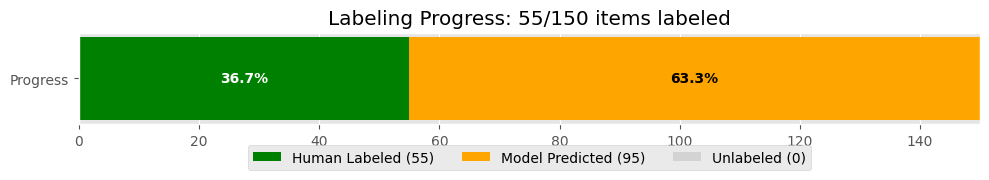

Iteration 3 => error rate in correction sample: 0.40

Iteration Statistics:


,iteration,new_labeled,corrected_sample,corrections_made,error_rate,total_labeled_so_far
0,1,5,5,4,0.8,35
1,2,5,5,3,0.6,45
2,3,5,5,2,0.4,55


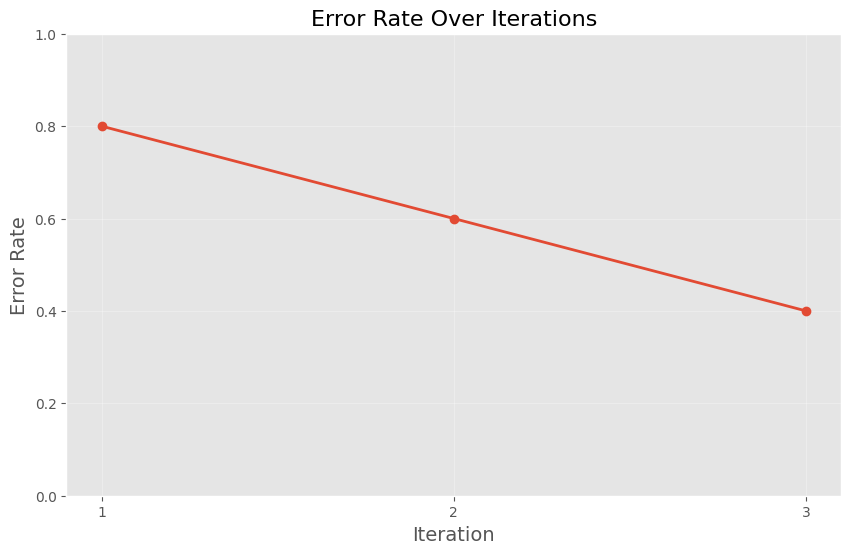

In [35]:
# Step 10: Run Multiple Iterations

# Let's do 3 iterations
for i in range(1, 4):
    df = run_iteration(df, iteration_id=i, label_count=5, correction_count=5)
    # If you run out of unlabeled items, we can break early
    if df["true_label"].isna().sum() == 0:
        print("All items labeled. Stopping early.")
        break

# Show the iteration stats
iters_df = pd.DataFrame(iteration_stats)
print("\nIteration Statistics:")
display(iters_df)

# Plot error rate over iterations
plt.figure(figsize=(10, 6))
plt.plot(iters_df["iteration"], iters_df["error_rate"], marker="o", linewidth=2)
plt.title("Error Rate Over Iterations", fontsize=16)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Error Rate", fontsize=14)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.xticks(iters_df["iteration"])
plt.show()

# LAB NOTES: Analyzing Improvement

## What We're Looking At:
1. Error rate trends over our iterations
2. Statistics on how many items we labeled and corrected in each round

## Expected Pattern:
* The error rate should generally decrease as we add more labeled examples
* The rate of improvement often slows down after initial iterations

## Discussion Questions:
* Did the error rate decrease as expected?
* At what point do we see diminishing returns?
* How might we decide when we have "enough" labeled data?

## Real-World Implications:
In federal agencies, this helps answer questions like:
- How much manual labeling effort is needed?
- How accurate is our automated classification?
- Can we trust the model to classify new variables?
- Should we adjust our categories to improve results?

Final visualization of Census variable classifications:
Calculating t-SNE projection (this may take a moment)...


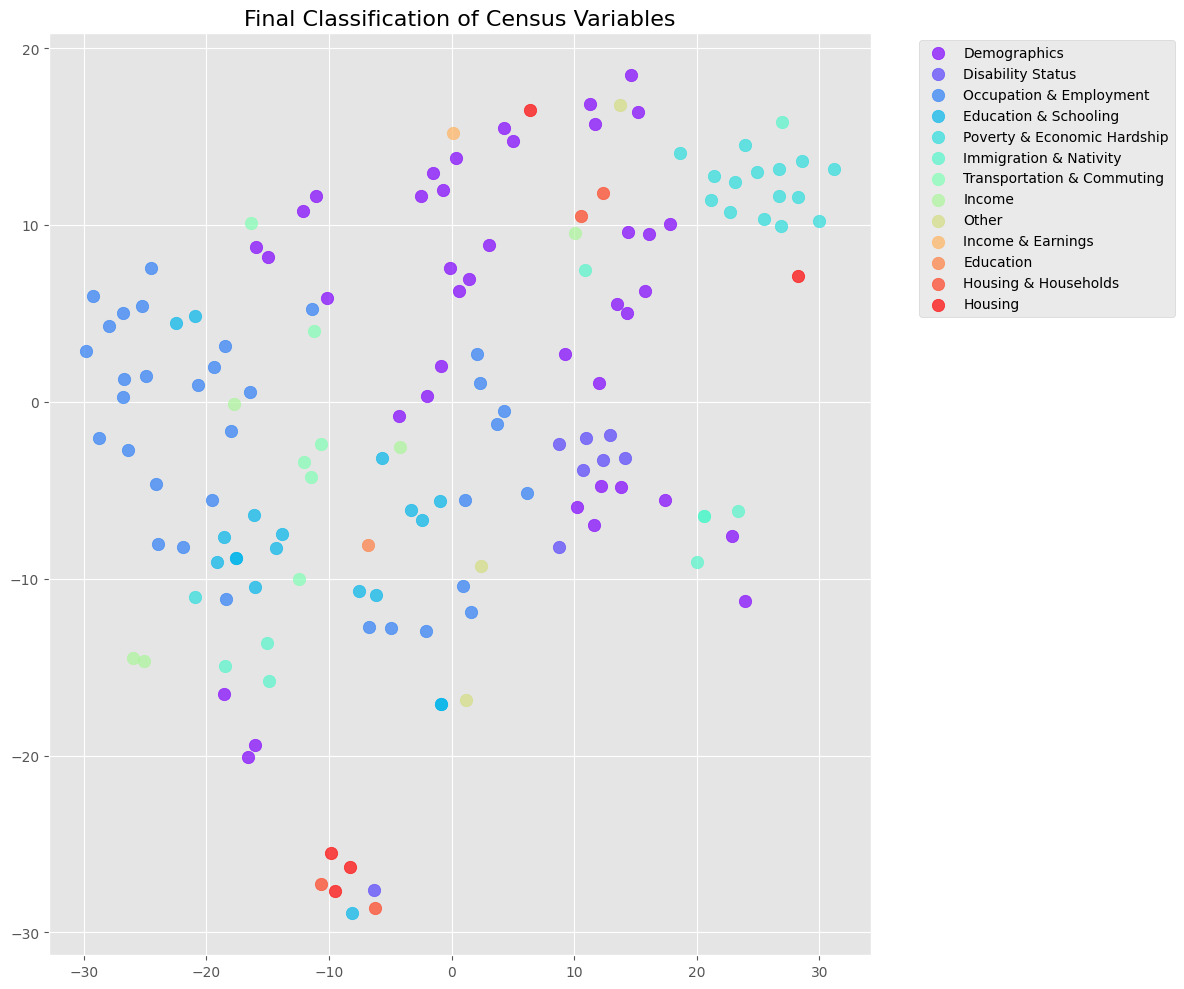

In [37]:
# Step 11: Final Visualization

# Create a final visualization with all our data
print("Final visualization of Census variable classifications:")

df_final = df.copy()
# For the final visualization, use true_label where available, otherwise predicted_label
df_final["final_label"] = df_final["true_label"].fillna(df_final["predicted_label"])
df_final["label_source"] = "Unlabeled"
df_final.loc[df_final["true_label"].notna(), "label_source"] = "Human Labeled"
df_final.loc[(df_final["true_label"].isna()) & (df_final["predicted_label"].notna()), "label_source"] = "Model Predicted"

visualize_embeddings(df_final, color_by="final_label", title="Final Classification of Census Variables")

# LAB NOTES: Final Visualization and Discussion

## What We've Accomplished:
1. Created BERT embeddings for Census variables
2. Manually labeled a subset of variables
3. Trained a classifier to predict the rest
4. Iteratively improved the model
5. Visualized the final classification

## Key Takeaways:
* Embeddings capture semantic meaning, allowing similar concepts to cluster
* A small amount of labeled data can go a long way with good embeddings
* Iterative improvement is a practical approach to ML development
* Visualization helps us understand both our data and our model

## Real-World Applications in Federal Agencies:
* Organizing large sets of statistical variables
* Creating metadata for data discovery
* Building taxonomies of government data
* Assisting with data harmonization across agencies
* Supporting data inventory and governance efforts

## Next Steps Discussion:
* How could we apply this to other types of federal data?
* What would be needed to deploy this in a production environment?
* How might we extend this to multilingual variable descriptions?
* Could we use this approach for public-facing data discovery tools?

# Summary: Teaching Points Covered

1. **Embeddings vs. Generation**: We demonstrated how BERT embeddings differ from GPT generation, focusing on understanding rather than creating text.

2. **Real-World Data**: We used actual Census variables from the ACS 5-Year estimates, making the exercise relevant to federal statistical agencies.

3. **Before vs. After Metrics**: We tracked error rates across iterations to quantify improvement and show the value of iterative labeling.

4. **Interactive Workflow**: The notebook encourages hands-on participation, with students labeling and correcting predictions.

5. **Visualization**: We showed how embeddings cluster similar concepts and how our classifications organize the data.

6. **Practical Application**: The techniques demonstrated can be applied directly to organizing federal statistical data.

# Suggestions for Further Exploration

## Try Different Models
- Compare with other BERT variants like 'all-mpnet-base-v2' 
- Test multilingual models for international applications

## Explore Other Classifiers
- Try logistic regression or SVM instead of KNN
- Experiment with different values of k (neighbors)

## Extend to Other Data Types
- Apply to survey questions
- Use with program descriptions
- Classify forms and applications

## Advanced Techniques (See Appendix)
- Uncertainty-based sampling
- Model calibration analysis
- Label quality assessment

---

# Appendix: 

## A1. Expanded Census Variable Categories with Definitions

### 1. Income & Earnings
**Definition:** Variables related to personal, household, or family income, including earnings from wages, salaries, self-employment, investments, retirement accounts, public assistance, and other financial resources. Also includes income distribution, income inequality measures, and income by demographic characteristics.

### 2. Housing & Households
**Definition:** Variables related to housing characteristics, housing value, rent, tenure (owner vs. renter), housing costs and affordability, household size, housing adequacy, housing age, facilities (plumbing, kitchen), housing density, vacancy rates, and mortgage status.

### 3. Poverty & Economic Hardship
**Definition:** Variables related to poverty status, poverty thresholds, ratio of income to poverty level, public assistance program participation, Supplemental Poverty Measure, food insecurity, economic hardship indicators, and depth of poverty.

### 4. Education & Schooling
**Definition:** Variables related to educational attainment, school enrollment, field of degree, school attendance, educational achievement, literacy, years of schooling completed, educational institution type, and education by demographic characteristics.

### 5. Demographics
**Definition:** Variables related to age, sex, race, ethnicity, ancestry, tribal affiliation, Hispanic origin, generation, marital status, and other core demographic characteristics of individuals and populations.

### 6. Healthcare & Insurance
**Definition:** Variables related to health insurance coverage, type of coverage (private, public, employer-provided), healthcare access, healthcare utilization, medical expenses, disability insurance, and Medicare/Medicaid enrollment.

### 7. Occupation & Employment
**Definition:** Variables related to labor force status, occupation, industry, class of worker, work experience, work schedule, employment status, unemployment, hours worked, earnings by occupation, and job characteristics.

### 8. Transportation & Commuting
**Definition:** Variables related to means of transportation to work, travel time, vehicle ownership, carpooling, public transportation usage, commuting patterns, vehicles available, and transportation costs.

### 9. Internet & Technology
**Definition:** Variables related to computer ownership, internet subscription, broadband access, smartphone usage, digital divide indicators, technology adoption, and internet usage by demographic characteristics.

### 10. Immigration & Nativity
**Definition:** Variables related to place of birth, duration of residence in the host country, citizenship status, year of entry into the country, naturalization, foreign-born status, country of birth, ancestry, legal permanent resident status, and visa type.

### 11. Language
**Definition:** Variables related to language spoken at home, English proficiency, linguistic isolation, bilingualism, multilingualism, ability to speak English, language other than English, and language by demographic characteristics.

### 12. Disability Status
**Definition:** Variables related to disability types (hearing, vision, cognitive, ambulatory, self-care, independent living), disability status by demographic characteristics, work limitations due to disability, and disability benefits.

### 13. Veteran Status
**Definition:** Variables related to veteran status, period of service, VA healthcare enrollment, service-connected disability rating, active duty status, and veterans by demographic characteristics.

### 14. Family Composition
**Definition:** Variables related to family type, family size, presence of children, parent-child relationships, multigenerational households, grandparents as caregivers, single-parent households, and family structure.

### 15. Geographic Mobility
**Definition:** Variables related to residence one year ago, migration patterns, internal migration, interstate migration, intrastate migration, mobility rates, reason for moving, and migration by demographic characteristics.

### 16. Other
**Definition:** Variables that don't fit clearly into the above categories, including voting registration, public program participation not related to poverty, fertility, and specialized topics not covered elsewhere.

---

## A2. Advanced Topics

The following sections contain advanced material that can be used for extended discussions or additional learning

## A2.1 Model Calibration

### What is Calibration?
Calibration measures how well the model's confidence scores align with actual accuracy.
In a perfectly calibrated model, predictions with 80% confidence would be correct 80% of the time.

### Why It Matters:
- Helps users know when to trust the model's predictions
- Identifies overconfidence or underconfidence
- Critical for decision-making in federal agencies

### How to Read the Calibration Curve:
- Points above the line: Model is underconfident (better than it thinks)
- Points below the line: Model is overconfident (worse than it thinks)
- Points on the line: Model is well-calibrated

### Real-World Application:
When classifying Census variables automatically, calibration helps decide:
- Which predictions need human review
- How to set confidence thresholds for automation
- How to communicate uncertainty to data users

In [40]:
# A2.1: Confidence Calibration

def analyze_model_calibration(df):
    """
    Analyze how well the model's confidence scores align with actual correctness.
    This helps understand if high confidence actually means high accuracy.
    """
    # We need both true_label and predicted_label and confidence
    mask = (df["true_label"].notna() & 
            df["predicted_label"].notna() & 
            df["confidence"].notna())
    
    if mask.sum() < 10:
        print("Not enough data points with both true labels and predictions.")
        return None
    
    df_eval = df[mask].copy()
    
    # Add a column indicating whether prediction was correct
    df_eval["correct"] = df_eval["true_label"] == df_eval["predicted_label"]
    
    # Group by confidence bins
    df_eval["confidence_bin"] = pd.cut(df_eval["confidence"], bins=10)
    
    # Calculate accuracy per bin
    calibration_df = df_eval.groupby("confidence_bin").agg(
        bin_accuracy=("correct", "mean"),
        bin_confidence=("confidence", "mean"),
        count=("correct", "count")
    ).reset_index()
    
    # Plot calibration curve
    plt.figure(figsize=(10, 6))
    
    # Plot the identity line (perfect calibration)
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
    
    # Plot the calibration curve
    plt.scatter(calibration_df["bin_confidence"], calibration_df["bin_accuracy"], 
                s=calibration_df["count"]*5, alpha=0.7)
    
    # Add count labels
    for _, row in calibration_df.iterrows():
        plt.annotate(f"{row['count']}", 
                    (row["bin_confidence"], row["bin_accuracy"]),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center')
    
    plt.xlabel('Mean Confidence')
    plt.ylabel('Observed Accuracy')
    plt.title('Calibration Curve (bubble size = count)')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return calibration_df

## A2.2: Active Learning Strategies

### What is Active Learning?
Active learning is a machine learning approach where the algorithm can query a human for labels, 
focusing on the most informative examples.

### Key Strategies:

#### 1. Uncertainty Sampling
- Select items the model is least confident about
- Our notebook implements this by sorting by confidence scores

#### 2. Diversity Sampling
- Select items that represent different regions of the feature space
- Ensures broad coverage of the domain

#### 3. Query-by-Committee
- Train multiple models and select items where they disagree
- More robust than single-model uncertainty

### Benefits for Federal Agencies:
- Reduces manual labeling effort
- Improves model performance faster
- Focuses expert attention where it's most needed
- Documents decision process for transparency

### Implementation:
In our notebook, we use a simple form of uncertainty sampling by showing:
- Items with the lowest confidence scores first
- This focuses human review on the most uncertain predictions
- More sophisticated strategies could be implemented for larger datasets

## A2.3: Applications Across Federal Statistical Agencies

### Census Bureau:
- Classifying American Community Survey (ACS) variables
- Organizing economic indicators
- Mapping industry and occupation codes
- Standardizing geographic entity descriptions

### Bureau of Labor Statistics:
- Classifying job descriptions
- Organizing wage and employment data
- Standardizing survey questions
- Mapping skills taxonomies

### Bureau of Economic Analysis:
- Categorizing economic time series
- Organizing industry accounts
- Mapping international trade categories
- Standardizing regional economic descriptions

### Department of Agriculture:
- Classifying agricultural products
- Organizing farm economic data
- Mapping land use categories
- Standardizing nutritional information

### Health and Human Services:
- Categorizing health indicators
- Organizing medical terminology
- Mapping healthcare utilization metrics
- Standardizing program descriptions

### Implementation Considerations:
- Data governance policies
- Model validation requirements
- Documentation standards
- Transparency in classification decisions
- Integration with existing metadata systems

## A2.4: Practical Deployment Tips

### Model Versioning:
- Track BERT model versions
- Document embedding generation process
- Version control labeled datasets
- Maintain classifier code and hyperparameters

### Quality Assurance:
- Establish review processes for labeled data
- Set accuracy thresholds for production use
- Create a feedback loop for incorrect classifications
- Regularly re-evaluate performance on new data

### Technical Infrastructure:
- API for embedding generation
- Database for storing embeddings
- Web interface for human labeling
- Monitoring system for model performance

### Documentation Requirements:
- Model cards detailing capabilities and limitations
- Data dictionaries for variable categories
- Decision logs for labeling criteria
- Performance metrics over time

### Governance Considerations:
- Who has authority to define categories?
- How often should the model be retrained?
- What level of human review is required?
- How are edge cases and ambiguities handled?

### Security and Privacy:
- Embedding data sensitivity assessment
- Access controls for classification system
- Audit logs for labeling activities
- Compliance with federal information security standards